In [12]:
import numpy as np
import numba as nb
from tqdm.notebook import trange, tqdm
from numba import njit, prange
from numba.typed import List
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib import animation

In [13]:
a = np.zeros(10, dtype=np.uint64)
b = np.frombuffer(a, dtype=np.uint16).reshape(-1, 4)


In [14]:
assert b.flags['C_CONTIGUOUS'] == True


In [15]:
@njit
def index_sorted(buf: np.ndarray, x: np.uint16, y: np.uint16):
    k = (np.uint32(x) << 32)+(np.uint32(y) << 48)
    idx = np.searchsorted(buf[1:buf[0]+np.uint64(1)], k)+1
    mask32_64 = np.uint64(18446744069414584320)
    if buf[idx] & mask32_64 == k and buf[0]+1 > idx:
        return idx
    else:
        assert buf.shape[0] > buf[0]+1
        buf[0] += 1
        buf[idx+1:buf[0]+np.uint64(1)] = buf[idx:buf[0]]
        buf[idx] = k
        return idx


@njit
def purge_index(buf: np.ndarray, idx: np.int32):
    buf[idx:buf[0]] = buf[idx+1:buf[0]+np.uint64(1)]
    buf[buf[0]] = 0
    buf[0] -= 1


@njit
def update_sorted(buf: np.ndarray, x: np.uint16, y: np.uint16, dv: np.uint16, u: np.uint16):
    idx = index_sorted(buf, x, y)
    mask0_15 = np.uint64(65535)
    mask32_64 = np.uint64(18446744069414584320)
    buf[idx] = ((mask32_64 & buf[idx])
                + np.uint64(np.uint32(u) << 16)
                + (mask0_15 & np.uint64(dv+buf[idx])))
    if ((mask0_15 & buf[idx])) == 0:
        purge_index(buf, idx)


@njit
def set_sorted(buf: np.ndarray, x: np.uint16, y: np.uint16, v: np.uint16, u: np.uint16):
    idx = index_sorted(buf, x, y)
    if v == 0 or u == 0:
        purge_coord_sorted(buf, x, y)
        return
    buf[idx] = (np.uint64(v)
                + (np.uint32(u) << 16)
                + (np.uint32(x) << 32)
                + (np.uint32(y) << 48))


@njit
def purge_coord_sorted(buf: np.ndarray, x: np.uint16, y: np.uint16):
    k = (np.uint32(x) << 32)+(np.uint32(y) << 48)
    idx = np.searchsorted(buf[1:buf[0]+np.uint64(1)], k)+1
    mask32_64 = np.uint64(18446744069414584320)
    if (buf[idx] & mask32_64) == k:
        purge_index(buf, idx)


In [16]:
@njit
def update_cell(lattice: np.ndarray, x: np.uint16, y: np.uint16, ds: np.uint16, dz: np.uint16, dr: np.uint16, s_buf64: np.ndarray, z_buf64: np.ndarray):
    s, z, r = lattice[x, y]
    lattice[x, y,0] += ds
    lattice[x, y,1] += dz
    lattice[x, y,2] += dr
    X, Y, _ = lattice.shape
    neighbors_xy = np.array([[-1, 0], [1, 0], [0, -1], [0, 1], [0, 0]], dtype=np.int32)
    neighbors_xy[:, 0] = (neighbors_xy[:, 0]+x) % X
    neighbors_xy[:, 1] = (neighbors_xy[:, 1]+y) % Y
    nzs = np.uint16(0)
    nss = np.uint16(0)
    if ds != 0:
        for nx, ny in neighbors_xy:
            nz = lattice[nx, ny, 1]
            nzs += nz
            if nz != 0 and (nx!=x or ny!=y):  # neighbor have Z!=0
                update_sorted(z_buf64, nx, ny, np.uint16(ds), nz)
        set_sorted(s_buf64, x, y, nzs, np.uint16(s+ds))
    elif s!=0:
        update_sorted(s_buf64, x, y, np.uint16(dz), np.uint16(s+ds))    
    if dz != 0:
        for nx, ny in neighbors_xy:
            ns = lattice[nx, ny, 0]
            nss += ns
            if ns != 0 and (nx!=x or ny!=y):  # neighbor have S!=0
                update_sorted(s_buf64, nx, ny, np.uint16(dz), ns)
        set_sorted(z_buf64, x, y, nss, np.uint16(z+dz))
    elif z!=0:
        update_sorted(z_buf64, x, y, np.uint16(ds), np.uint16(z+dz))


In [17]:
@njit
def weighted_sample(p: np.ndarray):
    cumulative_distribution = np.cumsum(p)
    a = np.float32(cumulative_distribution[-1])
    return np.searchsorted(cumulative_distribution, np.random.uniform(0, a), side="right")


@njit
def get_modified_xy(lattice: np.ndarray, initiator_xy: np.ndarray, target_idx: np.uint16):
    x, y = initiator_xy
    X, Y, _ = lattice.shape
    neighbors_xy = np.array(
        [[-1, 0], [1, 0], [0, -1], [0, 1], [0, 0]], dtype=np.int32)
    neighbors_xy[:, 0] = (neighbors_xy[:, 0]+x) % X
    neighbors_xy[:, 1] = (neighbors_xy[:, 1]+y) % Y
    p = np.empty(neighbors_xy.shape[0], dtype=np.uint16)
    for i in range(neighbors_xy.shape[0]):
        nx, ny = neighbors_xy[i]
        p[i] = lattice[nx, ny, target_idx]
    if np.sum(p) == 0:
        shape = lattice[x-np.uint(2):x+np.uint(3),
                        y-np.uint(2):y+np.uint(3), 0].shape
        ll = np.empty(shape)
        print(x, y)
        ll[:, :] = lattice[x-np.uint(2):x+np.uint(3),
                           y-np.uint(2):y+np.uint(3), 0]    
        ll[:, :] -= lattice[x-np.uint(2):x+np.uint(3),
                            y-np.uint(2):y+np.uint(3), 1]
        print(ll, target_idx)
        assert False
    return neighbors_xy[weighted_sample(p)]


In [18]:
@njit
def uszr_sample(lattice: np.ndarray, s_buf16: np.ndarray, z_buf16: np.ndarray, alpha: float = 0.25):
    # neighbor count, self count, x,y
    b = 1
    k = b*alpha
    K = k*s_buf16[0, 0]
    B = b*z_buf16[0, 0]
    dt = np.random.exponential(1/(K+B))
    if np.random.rand() < K/(K+B):
        buf16 = s_buf16[1:s_buf16[0, 0]+np.uint16(1)]
        dszr = (np.uint16(0), np.uint16(-1), np.uint16(1))
        idx = 1
    else:
        buf16 = z_buf16[1:z_buf16[0, 0]+np.uint16(1)]
        idx = 0
        dszr = (np.uint16(-1), np.uint16(1), np.uint16(0))

    initiator_idx = weighted_sample(buf16[:, 1])
    initiator_xy = buf16[initiator_idx, 2:]
    x, y = get_modified_xy(lattice, initiator_xy, np.uint16(idx))

    return x, y, dszr, dt

@njit
def szr_sample(lattice: np.ndarray, s_buf16: np.ndarray, z_buf16: np.ndarray, alpha: float = 0.25):
    # neighbor count, self count, x,y
    b = 1
    k = b*alpha
    ls=s_buf16[0,0]+np.uint(1)
    lz=z_buf16[0,0]+np.uint(1)
    ps=np.sum(s_buf16[1:ls,0]*s_buf16[1:ls,1])
    pz=np.sum(z_buf16[1:lz,0]*z_buf16[1:lz,1])
    if ps!=pz:
        print(s_buf16[1:ls])
        print(z_buf16[1:lz])
        print(ps,pz)
        print(lattice[:,:,0])
        print(lattice[:,:,1])
        assert False
    K = k*ps
    B = b*pz
    dt = np.random.exponential(1/(K+B))
    if np.random.rand() < K/(K+B):
        buf16 = s_buf16[1:s_buf16[0, 0]+np.uint16(1)]
        dszr = (np.uint16(0), np.uint16(-1), np.uint16(1))
        idx = 1
    else:
        buf16 = z_buf16[1:z_buf16[0, 0]+np.uint16(1)]
        idx = 0
        dszr = (np.uint16(-1), np.uint16(1), np.uint16(0))

    initiator_idx = weighted_sample(buf16[:, 1]*buf16[:, 0])
    initiator_xy = buf16[initiator_idx, 2:]
    x, y = get_modified_xy(lattice, initiator_xy, np.uint16(idx))

    return x, y, dszr, dt


In [19]:
def run_lattice(lattice: np.ndarray, s_buf64: np.ndarray, z_buf64: np.ndarray, alpha: float, uszr: bool = True):
    s_buf16 = np.frombuffer(s_buf64, dtype=np.uint16).reshape(-1, 4)
    z_buf16 = np.frombuffer(z_buf64, dtype=np.uint16).reshape(-1, 4)
    ms = 0
    mz = 0
    T = 0.
    if uszr:
        sample = uszr_sample
    else:
        sample = szr_sample
    for i in trange(np.sum(lattice[:, :, :2])*2):
        if s_buf64[0] > ms:
            ms = s_buf64[0]
        if z_buf64[0] > mz:
            mz = z_buf64[0]
        if s_buf64[0] != 0 and z_buf64[0] != 0:
            x, y, (ds, dz, dr), dt = sample(lattice, s_buf16, z_buf16, alpha)
            T += dt
            update_cell(lattice, x, y, ds, dz, dr, s_buf64, z_buf64)
        else:
            print('max S, Z buf sizes:', ms, mz)
            print('Time elapsed:', T)
            assert z_buf64[0] == 0 and s_buf64[0] == 0
            break


In [20]:
@njit
def nb_seed(seed):
    np.random.seed(seed)

In [21]:
np.set_printoptions(threshold=np.inf,linewidth=100000)

In [22]:
def exec(L:int,seed:int,alpha:float=0.25,uszr:bool=True,thickness:int=1):
    nb_seed(seed)
    lattice = np.zeros((L, L, 3), dtype=np.uint16)
    lattice[:, :, 0] = thickness
    s_buf64 = np.zeros((L*10*thickness), dtype=np.uint64)
    z_buf64 = np.zeros((L*10*thickness), dtype=np.uint64)

    update_cell(lattice, np.uint16(0), np.uint16(0), np.uint16(-thickness), np.uint16(thickness), np.uint16(0), s_buf64, z_buf64)
    run_lattice(lattice,s_buf64,z_buf64,alpha,uszr)
    return lattice

In [23]:
def plt_lattice(lattice: np.ndarray):
    patches = [mpatches.Patch(color=(1, 0, 0), label="Z"),
               mpatches.Patch(color=(0, 1, 0), label="S"),
               mpatches.Patch(color=(0, 0, 1), label="R")
               ]
    lattice_fig = np.empty_like(lattice, dtype=np.float32)
    th = np.max(lattice)
    lattice_fig[:, :, 0] = lattice[:, :, 1]
    lattice_fig[:, :, 1] = lattice[:, :, 0]
    lattice_fig[:, :, 2] = lattice[:, :, 2]
    plt.figure(figsize=(6, 6),dpi=150)
    plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc=0, borderaxespad=0.,prop={'size': 10})
    plt.imshow(lattice_fig/th,interpolation='None')

    plt.draw()


In [13]:
lattice_szr=exec(2048,0,alpha=0.437,uszr=False,thickness=1)

  0%|          | 0/8388608 [00:00<?, ?it/s]

max S, Z buf sizes: 2007 1542
Time elapsed: 3562.0546064877967


In [14]:
lattice_uszr=exec(2048,0,alpha=0.253,uszr=True,thickness=1)

  0%|          | 0/8388608 [00:00<?, ?it/s]

max S, Z buf sizes: 1391 1019
Time elapsed: 7373.7979961050905


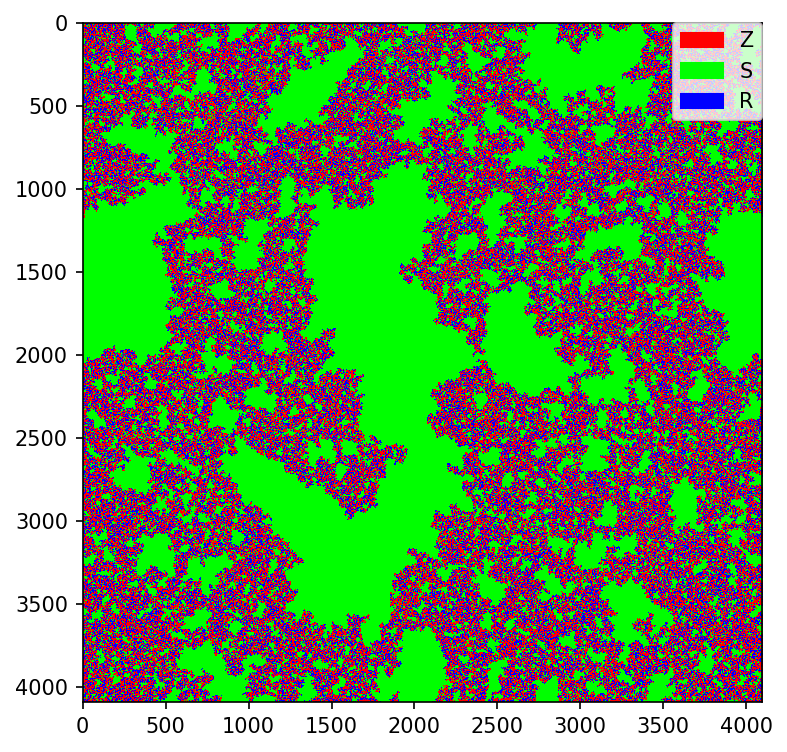

In [50]:
plt_lattice(lattice_szr)

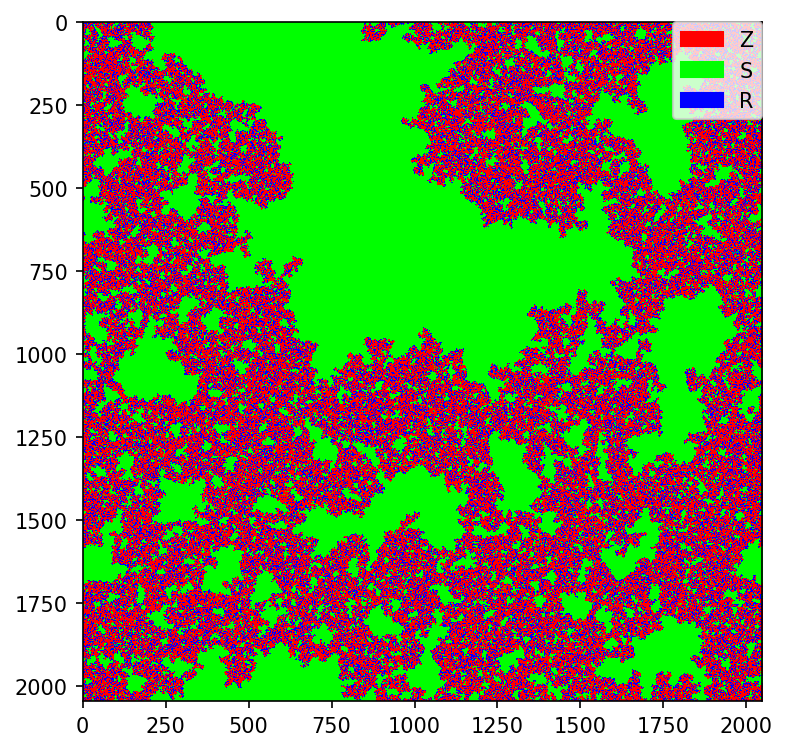

In [46]:
plt_lattice(lattice_uszr)

In [17]:
lattice_szr2=exec(1024,4,alpha=0.65,uszr=False,thickness=2)

  0%|          | 0/4194304 [00:00<?, ?it/s]

max S, Z buf sizes: 4011 2892
Time elapsed: 632.8608691570752


In [43]:
plt_lattice(lattice_szr2)

NameError: name 'lattice_szr2' is not defined

In [19]:
lattice_uszr2=exec(1024,0,alpha=0.32,uszr=True,thickness=2)

  0%|          | 0/4194304 [00:00<?, ?it/s]

max S, Z buf sizes: 1091 769
Time elapsed: 4476.06973044114


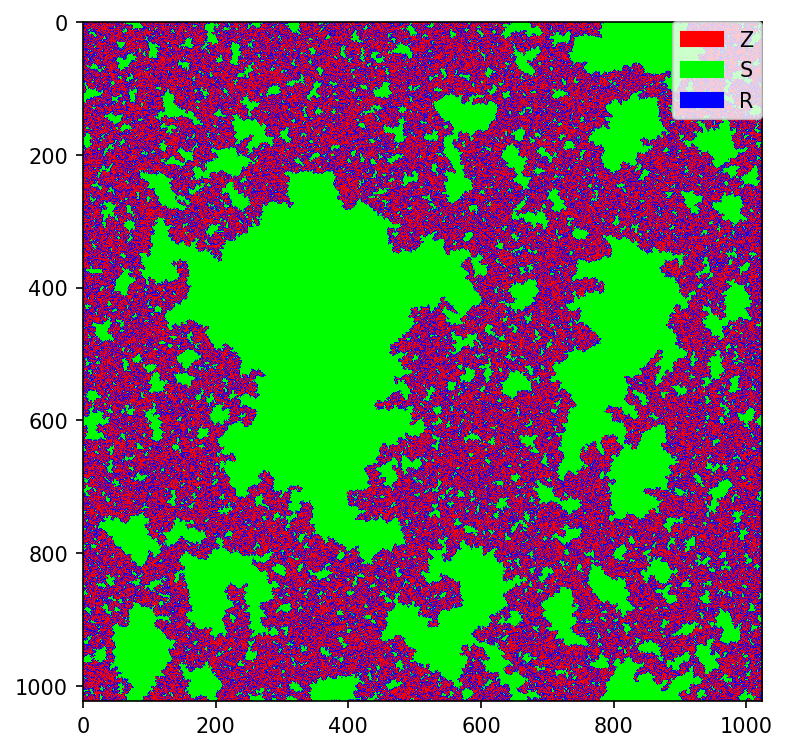

In [20]:
plt_lattice(lattice_uszr2)

In [21]:
lattice_szr3=exec(1024,0,alpha=0.75,uszr=False,thickness=3)

  0%|          | 0/6291456 [00:00<?, ?it/s]

max S, Z buf sizes: 4378 3046
Time elapsed: 370.47641385668754


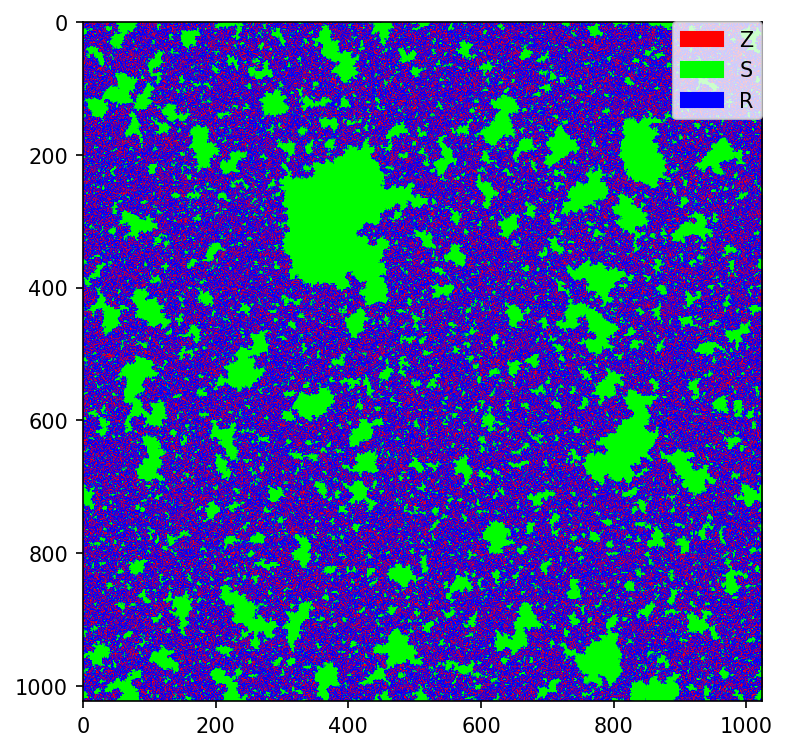

In [22]:
plt_lattice(lattice_szr3)

In [23]:
lattice_uszr3=exec(1024,1,alpha=0.347,uszr=True,thickness=3)

  0%|          | 0/6291456 [00:00<?, ?it/s]

max S, Z buf sizes: 1735 1236
Time elapsed: 4116.25186560902


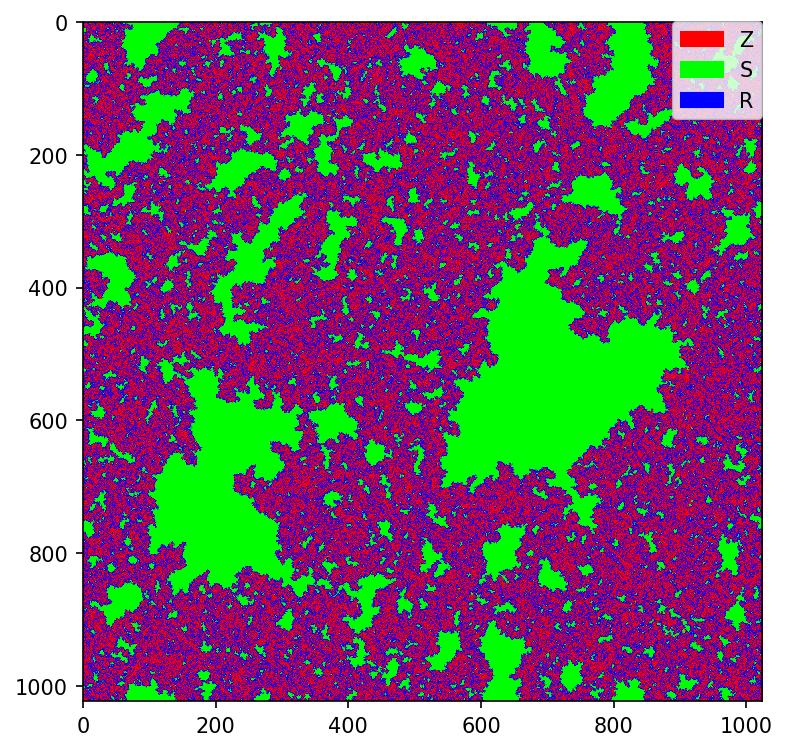

In [24]:
plt_lattice(lattice_uszr3)

In [47]:
lattice_uszr10=exec(2048,1,alpha=0.41,uszr=True,thickness=10)

  0%|          | 0/83886080 [00:00<?, ?it/s]

max S, Z buf sizes: 1883 1607
Time elapsed: 34683.904900165784


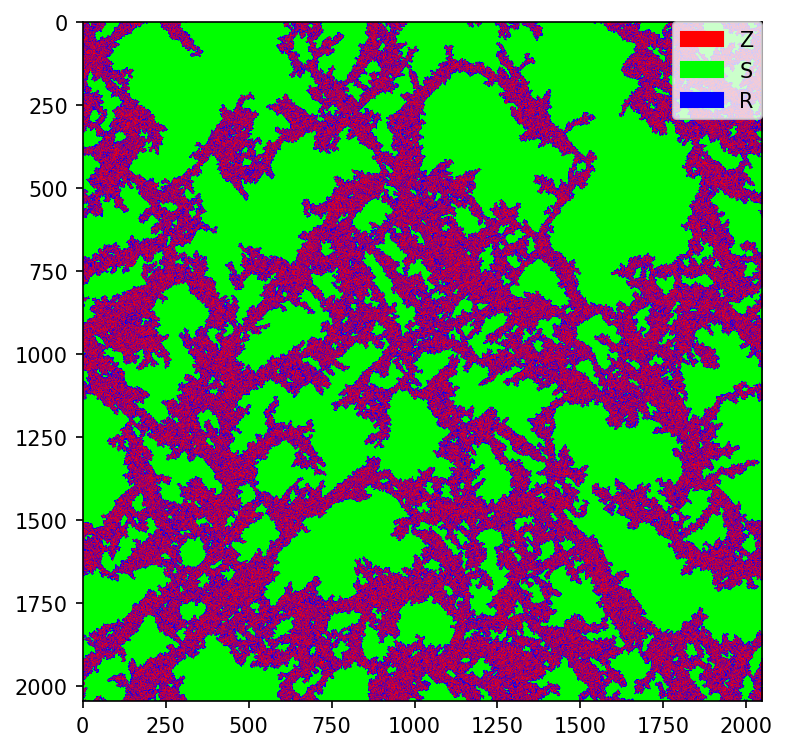

In [48]:
plt_lattice(lattice_uszr10)

In [27]:
lattice_uszr100=exec(256,1,alpha=0.45,uszr=True,thickness=100)

  0%|          | 0/13107200 [00:00<?, ?it/s]

max S, Z buf sizes: 503 476
Time elapsed: 23875.893190028066


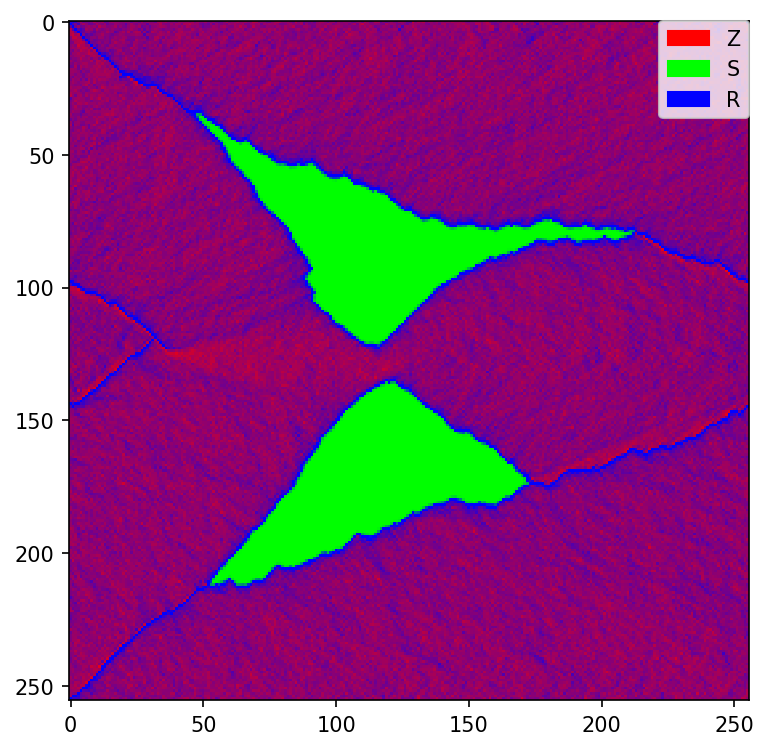

In [28]:
plt_lattice(lattice_uszr100)

In [29]:
def gen_image(L: int, seed: int, alpha: float = 0.25, uszr: bool = True, thickness: int = 1, frame_distance: int = 5):
    nb_seed(seed)
    lattice = np.zeros((L, L, 3), dtype=np.uint16)
    lattice[:, :, 0] = thickness
    s_buf64 = np.zeros((L*10*thickness), dtype=np.uint64)
    z_buf64 = np.zeros((L*10*thickness), dtype=np.uint64)
    s_buf16 = np.frombuffer(s_buf64, dtype=np.uint16).reshape(-1, 4)
    z_buf16 = np.frombuffer(z_buf64, dtype=np.uint16).reshape(-1, 4)
    update_cell(lattice, np.uint16(0), np.uint16(0), np.uint16(-thickness),
                np.uint16(thickness), np.uint16(0), s_buf64, z_buf64)
    lattice_fig = np.empty_like(lattice, dtype=np.float32)
    th = np.max(lattice)
    T = 0.
    T0 = 0
    if uszr:
        sample = uszr_sample
    else:
        sample = szr_sample

    for i in trange(np.sum(lattice[:, :, :2])*2):
        if T >= T0:
            T0+=frame_distance
            lattice_fig[:, :, 0] = lattice[:, :, 1]
            lattice_fig[:, :, 1] = lattice[:, :, 0]
            lattice_fig[:, :, 2] = lattice[:, :, 2]
            yield lattice_fig/th,T
        if s_buf64[0] != 0 and z_buf64[0] != 0:
            x, y, (ds, dz, dr), dt = sample(lattice, s_buf16, z_buf16, alpha)
            T += dt
            update_cell(lattice, x, y, ds, dz, dr, s_buf64, z_buf64)
        else:
            assert z_buf64[0] == 0 and s_buf64[0] == 0
            break


In [30]:
def updatefig(lattice_T):
    lattice,T=lattice_T
    global ann
    ann.set_text('T:{:.5f}'.format(T))
    im=plt.imshow(lattice)
    return im,

  0%|          | 0/13107200 [00:00<?, ?it/s]

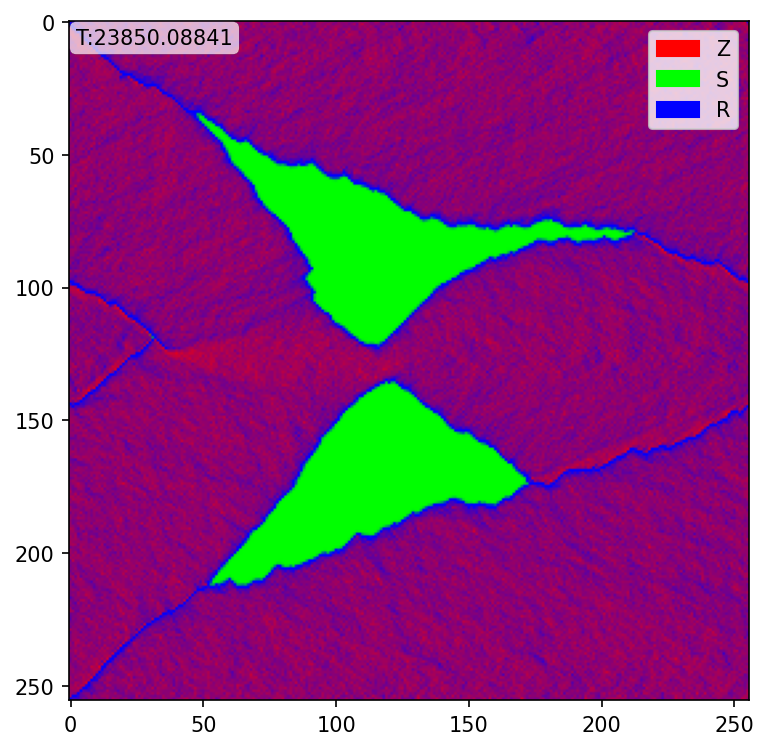

In [31]:
fig=plt.figure(figsize=(6,6),dpi=150)
ann=plt.annotate("T:0.00000",xy=(0.01, 0.966),xycoords='axes fraction',bbox=dict(boxstyle='round', facecolor='white', alpha=0.7,linewidth=0.1),)
patches = [mpatches.Patch(color=(1, 0, 0), label="Z"),
            mpatches.Patch(color=(0, 1, 0), label="S"),
            mpatches.Patch(color=(0, 0, 1), label="R")
            ]
plt.legend(handles=patches)
frames=gen_image(256,1,alpha=0.45,uszr=True,thickness=100,frame_distance=50)
ani = animation.FuncAnimation(fig, updatefig, blit=True, frames=frames, save_count=99999)
ani.save('Z:/256x100.mp4', fps=60, extra_args=['-vcodec', 'libx264'])

  0%|          | 0/5242880 [00:00<?, ?it/s]

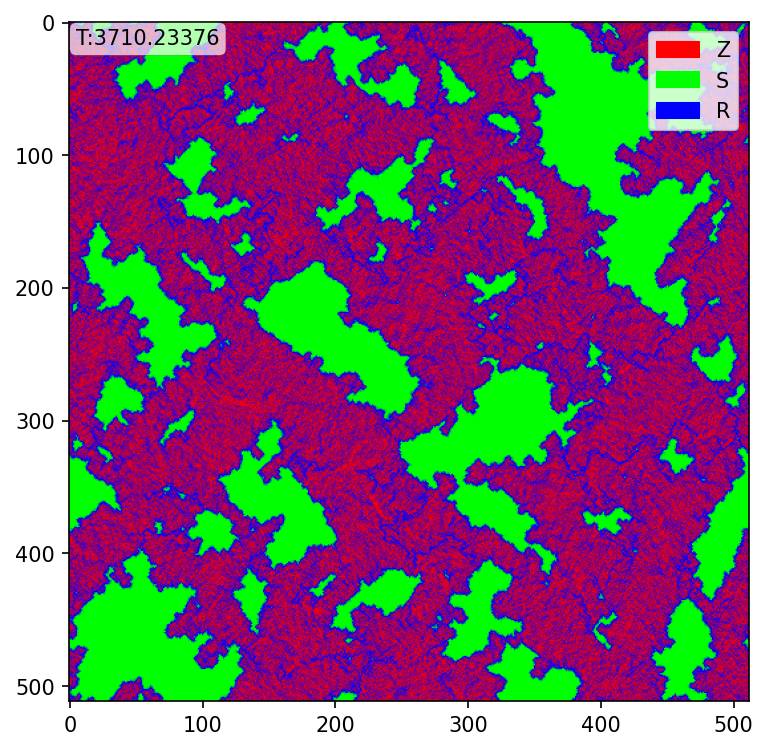

In [35]:
fig=plt.figure(figsize=(6,6),dpi=150)
ann=plt.annotate("T:0.00000",xy=(0.01, 0.966),xycoords='axes fraction',bbox=dict(boxstyle='round', facecolor='white', alpha=0.7,linewidth=0.1),)
patches = [mpatches.Patch(color=(1, 0, 0), label="Z"),
            mpatches.Patch(color=(0, 1, 0), label="S"),
            mpatches.Patch(color=(0, 0, 1), label="R")
            ]
plt.legend(handles=patches)
frames=gen_image(512,1,alpha=0.41,uszr=True,thickness=10,frame_distance=10)
ani = animation.FuncAnimation(fig, updatefig, blit=True, frames=frames, save_count=99999)
ani.save('Z:/512x10.mp4', fps=60, extra_args=['-vcodec', 'libx264'])

In [119]:
@njit
def cluster_size(L:int,seed:int,alpha:float=0.25,thickness:float=1,uszr:bool=True):
    nb_seed(L)
    lattice = np.zeros((L, L, 3), dtype=np.uint16)
    v=int(np.floor(thickness))
    lattice[:,:,0]=v
    lattice[:,:,0]+=(np.random.rand(L,L)<thickness-v)
    nb_seed(seed)
    thickness=int(np.ceil(thickness))
    
    
    
    s_buf64 = np.zeros((L*10*thickness), dtype=np.uint64)
    z_buf64 = np.zeros((L*10*thickness), dtype=np.uint64)
    s_buf16 = np.frombuffer(s_buf64, dtype=np.uint16).reshape(-1, 4)
    z_buf16 = np.frombuffer(z_buf64, dtype=np.uint16).reshape(-1, 4)

    update_cell(lattice, np.uint16(0), np.uint16(0), np.uint16(-lattice[0,0,0]), np.uint16(lattice[0,0,0]), np.uint16(0), s_buf64, z_buf64)

    for i in range(np.sum(lattice[:, :, :2])*2):
        if s_buf64[0] != 0 and z_buf64[0] != 0:
            if uszr is True:
                x, y, (ds, dz, dr), dt = uszr_sample(lattice, s_buf16, z_buf16, alpha)
            else:
                x, y, (ds, dz, dr), dt = szr_sample(lattice, s_buf16, z_buf16, alpha)
            update_cell(lattice, x, y, ds, dz, dr, s_buf64, z_buf64)
        else:
            assert z_buf64[0] == 0 and s_buf64[0] == 0
            break
    return np.sum(lattice[:,:,1:])


In [120]:
@njit(parallel=True)
def batch_clusters_size(L:int,seed_init:int,alpha:float=0.25,thickness:int=1,run_number:int=128,uszr:bool=True):
    res_container=np.empty(run_number,dtype=np.int64)
    for i in prange(run_number):
        res_container[i]=cluster_size(L,seed_init+i,alpha=alpha,thickness=thickness,uszr=uszr)
    return res_container

$$

$$\sigma_{n_{\ge s}}^2=N\cdot p\cdot q=n_{\ge s}\cdot(N-n_{\ge s})/N$$
$$\sigma_p^2=n_{\ge s}\cdot(N-n_{\ge s})/N^3$$
$$\sigma_y^2=\sigma_{p\cdot s^{2-\tau}}^2=n_{\ge s}\cdot(N-n_{\ge s})/N^3\cdot s^{2\cdot(2-\tau)}\propto n_{\ge s}\cdot(N-n_{\ge s})\cdot s^{2\cdot(2-\tau)}$$

$$w\propto 1/w\propto \frac{s^{\tau-2}}{\sqrt{n_{\ge s}\cdot(N-n_{\ge s})}}

In [121]:
def get_fit(sizes:np.ndarray,const:float=2-187/91):
    n,s=np.histogram(sizes,bins=100)
    s=np.convolve(s,(0.5,0.5),'valid')
    p=n/n.sum()
    p[::-1]=np.cumsum(p[::-1])
    x=np.power(s,36/91)
    y=p*np.power(s,187/91-2)
    w=np.power(s,187/91-2)*np.power(n*(n.sum()-n)+1,-0.5)
    best_cov=np.array([[np.inf,np.inf],[np.inf,np.inf]])
    best_fit=np.array([-1,-1])
    l=np.max(x)

    for low in np.linspace(int(0.1*l),int(0.28*l)):
        for high in np.linspace(int(0.6*l),int(0.9*l)):
            mask=(high>=x)&(x>=low)
            if np.sum(mask)<10:
                continue
            try:
                fit,cov=np.polyfit(x[mask],y[mask],w=w[mask],deg=1,cov=True)
            except:
                cov=np.array([[np.inf,np.inf],[np.inf,np.inf]])
            if cov[0,0]<best_cov[0,0]:
                best_cov=cov
                best_fit=fit
    return best_fit,best_cov

In [122]:
def plt_critical(sizes):
    (k,b),cov=get_fit(sizes)
    p,s=np.histogram(sizes,bins=100)
    s=np.convolve(s,(0.5,0.5),'valid')
    p=p/p.sum()
    p=np.cumsum(p[::-1])[::-1]
    x=np.power(s,36/91)
    y=p*np.power(s,187/91-2)
    plt.plot(x,y)
    plt.plot([0,x[-1]],[b,b+k*x[-1]])
    plt.annotate("δ:{:.6f}".format(k),xy=(0,0))
    plt.draw()
    

In [123]:
def alpha_search(L:int,seed_init:int,alpha_low:float,alpha_high:float,thickness=1,batch=1000,epsilon=0.,max_step=20,uszr=True):
    const=2-187/91
    last_delta=np.inf
    last_alpha_low=alpha_low
    last_alpha_high=alpha_high
    his=np.empty((max_step,2))
    for i in range(max_step):
        print('[{:.5f},{:.5f}]'.format(alpha_low,alpha_high))
        alpha=0.5*(alpha_high+alpha_low)
        sizes=batch_clusters_size(L,seed_init,alpha=alpha,thickness=thickness,run_number=batch,uszr=uszr)
        fit,cov=get_fit(sizes,const)
        delta=fit[0]
        sigma=np.sqrt(cov[0,0])
        thres=max(epsilon,2.5*sigma)
        his[i]=alpha,delta
        if delta>thres:
            last_alpha_low=alpha_low
            alpha_low=alpha
            if delta>last_delta and last_delta>0:
                alpha_high=last_alpha_high
            last_delta=delta
            print(alpha,delta)
        elif delta<-thres:
            last_alpha_high=alpha_high
            alpha_high=alpha
            if delta<last_delta and last_delta<0:
                alpha_low=last_alpha_low
            last_delta=delta
            print(alpha,delta)
        else:
            print(alpha,delta)
            return alpha,(alpha_high-alpha),fit,sizes,his[:i+1],cov
    return alpha,(alpha_high-alpha),fit,sizes,his[:i+1],cov

[0.00000,0.10000]
0.05 -0.002242307652380145
[0.00000,0.05000]
0.025 -0.020008494972648016
[0.00000,0.02500]
0.0125 -0.003936087486535908
[0.00000,0.01250]
0.00625 0.0036916545081048992
[0.00625,0.01250]
0.009375000000000001 0.0013380283704819307
[0.00938,0.01250]
0.010937500000000001 0.001855088220665448
[0.01094,0.02500]
0.017968750000000002 -0.010468782530594228
[0.01094,0.01797]
0.014453125 -0.0015357996985805801
[0.01094,0.01445]
0.0126953125 -0.004705275668112674
[0.00938,0.01270]
0.01103515625 0.00017044599230722193
found α=0.01104±0.00166
Wall time: 5min 22s


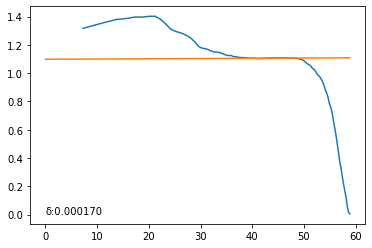

In [124]:
%%time
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0,0.1,0.6,batch=1024,uszr=False,max_step=20)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 1.86902344e-08, -8.24848825e-07],
       [-8.24848825e-07,  3.65276931e-05]])

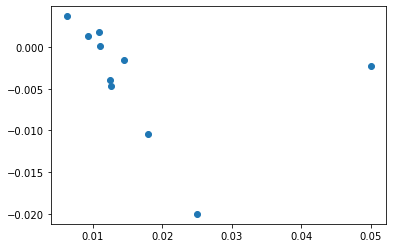

In [125]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.10000,0.40000]
0.25 -0.004308603711097869
[0.10000,0.25000]
0.175 0.004384864471602964
[0.17500,0.25000]
0.2125 -0.016406152161551873
[0.17500,0.21250]
0.19374999999999998 0.001990118065206353
[0.19375,0.21250]
0.203125 -0.006469517540792732
[0.19375,0.20312]
0.1984375 -0.0012311760751508138
[0.19375,0.19844]
0.19609374999999998 0.0006952320590801768
[0.19609,0.19844]
0.197265625 1.1577359916601686e-05
found α=0.19727±0.00117
Wall time: 6min 4s


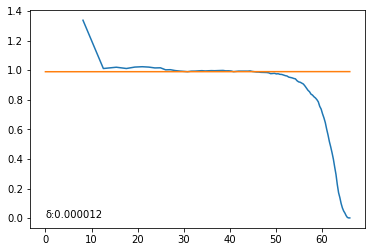

In [126]:
%%time
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.1,0.4,0.743656365691809,batch=1024,uszr=False,max_step=20)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 3.95120637e-09, -1.53852081e-07],
       [-1.53852081e-07,  6.10413434e-06]])

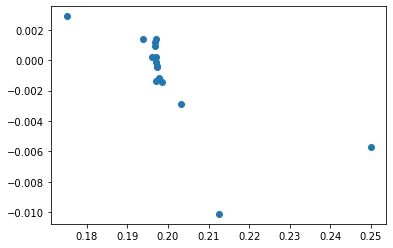

In [117]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.42000,0.45000]
0.435 0.0006996603042466836
[0.43500,0.45000]
0.4425 -0.0044040049461202165
[0.43500,0.44250]
0.43875 -0.00028758486671573056
[0.43500,0.43875]
0.436875 -0.00012299883755313425
[0.43500,0.43688]
0.4359375 0.00015143777294938913
[0.43594,0.43688]
0.43640625 0.0003782066334830442
[0.43641,0.43875]
0.437578125 -0.00037062293716969615
[0.43641,0.43758]
0.4369921875 -7.620065710052332e-05
found α=0.43699±0.00059
Wall time: 6min 50s


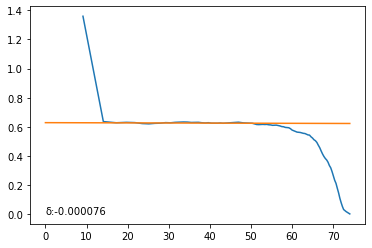

In [18]:
%%time
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.42,0.45,1,batch=1024,uszr=False)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 1.12566050e-09, -4.27620910e-08],
       [-4.27620910e-08,  1.66712181e-06]])

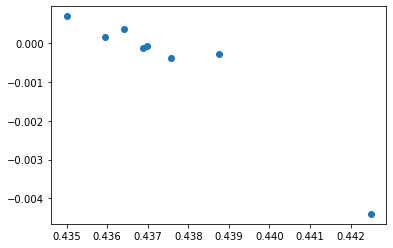

In [19]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.43000,0.55000]
0.49 -0.0012962097215539314
[0.43000,0.49000]
0.45999999999999996 0.0033630684455053152
[0.46000,0.49000]
0.475 0.0033485642196390813
[0.47500,0.49000]
0.4825 0.00272297202412905
[0.48250,0.49000]
0.48624999999999996 0.0019752957381937554
[0.48625,0.49000]
0.488125 0.0006337240421948709
[0.48812,0.49000]
0.48906249999999996 0.0010120230271288984
[0.48906,0.55000]
0.51953125 -0.004462313618320593
[0.48906,0.51953]
0.504296875 -0.007972888184768991
[0.48812,0.50430]
0.4962109375 -0.003973510490991049
[0.48812,0.49621]
0.49216796875 -0.0008226740228485836
[0.48812,0.49217]
0.49014648437499997 0.00018834767546083167
[0.49015,0.49217]
0.4911572265625 0.000930179681467397
[0.49116,0.49621]
0.49368408203125 -0.0018650224367891646
[0.49116,0.49368]
0.492420654296875 -0.0009037734125996864
[0.49116,0.49242]
0.49178894042968746 -9.085972085192017e-05
found α=0.49179±0.00063
Wall time: 23min 45s


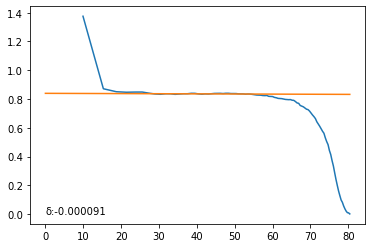

In [156]:
%%time
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.43,0.55,1.25,batch=1024,uszr=False)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 3.44500165e-09, -1.52992201e-07],
       [-1.52992201e-07,  6.87470500e-06]])

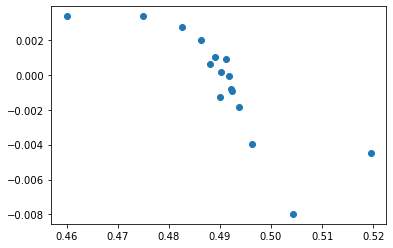

In [157]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.43000,0.66000]
0.545 0.0004764657795537639
[0.54500,0.66000]
0.6025 -0.008048508850362221
[0.54500,0.60250]
0.57375 -0.015082619517800759
[0.43000,0.57375]
0.501875 0.003022035566527204
[0.50187,0.57375]
0.5378125 0.001990349621788604
[0.53781,0.57375]
0.55578125 -0.0064642282543240955
[0.53781,0.55578]
0.5467968750000001 0.00027836551187242903
[0.54680,0.55578]
0.5512890625 -0.0013498107445769699
[0.54680,0.55129]
0.54904296875 -0.001015886750752266
[0.54680,0.54904]
0.547919921875 -0.0006675494455841483
[0.54680,0.54792]
0.5473583984375001 -0.00034260373290817694
[0.54680,0.54736]
0.5470776367187501 -0.0003479850164790699
[0.53781,0.54708]
0.5424450683593751 0.0016020500562468256
[0.54245,0.54708]
0.5447613525390627 0.000844150489052654
[0.54476,0.54708]
0.5459194946289063 0.00012341789792965648
found α=0.54592±0.00116
Wall time: 25min 12s


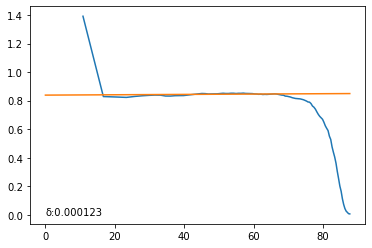

In [151]:
%%time
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.43,0.66,1.5,batch=1024,uszr=False)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 2.69090185e-09, -1.45275458e-07],
       [-1.45275458e-07,  8.06927435e-06]])

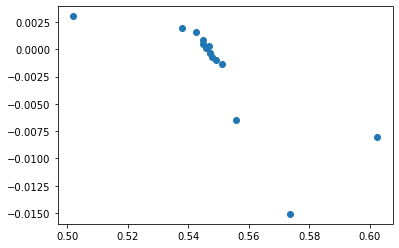

In [152]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.55000,0.66000]
0.605 0.0005398808851563997
[0.60500,0.66000]
0.6325000000000001 -0.008492099760687027
[0.60500,0.63250]
0.61875 -0.006408826059531763
[0.60500,0.61875]
0.611875 -0.0029640811757686634
[0.60500,0.61187]
0.6084375 -0.00045334114352482116
[0.60500,0.60844]
0.60671875 -0.00020842542878285
[0.60500,0.60672]
0.605859375 0.00046173320121191
[0.60586,0.60672]
0.6062890624999999 -0.0004541341110223569
[0.60586,0.60629]
0.6060742187499999 0.0004071264623302839
[0.60607,0.60629]
0.6061816406249999 -2.557682853306057e-05
found α=0.60618±0.00011
Wall time: 15min 48s


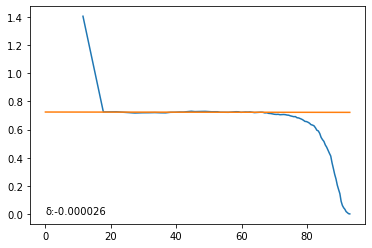

In [158]:
%%time
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.55,0.66,1.75,batch=1024,uszr=False)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 1.41107612e-09, -7.92956859e-08],
       [-7.92956859e-08,  4.56917252e-06]])

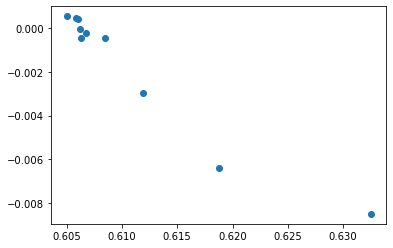

In [159]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.63000,0.68000]
0.655 0.0014056782063040544
[0.65500,0.68000]
0.6675 -0.0028058850361024016
[0.65500,0.66750]
0.66125 -0.00046770498597759606
[0.65500,0.66125]
0.6581250000000001 0.0009232101636512651
[0.65813,0.66125]
0.6596875 0.00032688054878777736
[0.65969,0.66125]
0.6604687499999999 0.0003093763646945962
[0.66047,0.66125]
0.660859375 -0.00025467069295854723
[0.66047,0.66086]
0.6606640625 -0.0004409222862863165
[0.65969,0.66066]
0.66017578125 0.00014242745124131616
[0.66018,0.66066]
0.660419921875 0.00016272646568191051
[0.66042,0.66086]
0.6606396484375 -0.00021306616074407637
[0.66042,0.66064]
0.6605297851562499 -2.74373555160322e-06
found α=0.66053±0.00011
Wall time: 23min 17s


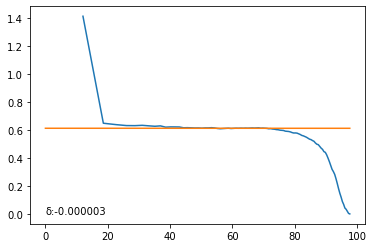

In [20]:
%%time
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.63,0.68,2,batch=1024,uszr=False)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 1.68393614e-09, -1.04106651e-07],
       [-1.04106651e-07,  6.49739357e-06]])

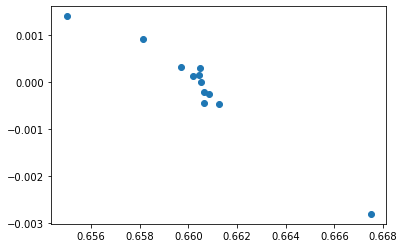

In [21]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.70000,0.80000]
0.75 0.001606083156878212
[0.75000,0.80000]
0.775 -0.006605684365993334
[0.75000,0.77500]
0.7625 -0.002067272091943638
[0.75000,0.76250]
0.75625 0.0007285323378926705
[0.75625,0.76250]
0.7593749999999999 6.106329620151002e-05
[0.75937,0.76250]
0.7609374999999999 -0.0013616131351418103
[0.75937,0.76094]
0.7601562499999999 -0.0014348247366929442
[0.75625,0.76016]
0.7582031249999999 5.5185164107353365e-05
found α=0.75820±0.00195
Wall time: 23min 4s


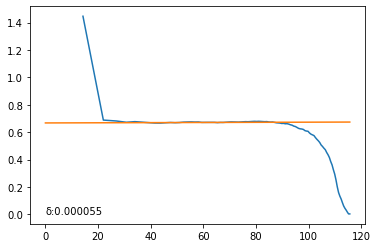

In [22]:
%%time
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.7,0.8,3,batch=1024,uszr=False)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 7.15949677e-10, -4.53092429e-08],
       [-4.53092429e-08,  2.90260000e-06]])

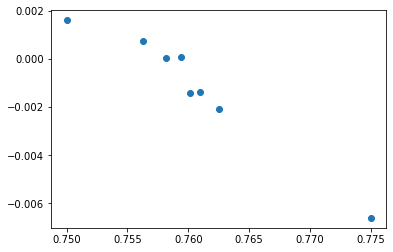

In [23]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

In [ ]:
np.exp(np.exp(-b/k))/4

0.44060711657265816

[0.75000,1.00000]
0.875 -0.005761788659891029
[0.75000,0.87500]
0.8125 -0.0005826423879641955
[0.75000,0.81250]
0.78125 0.001853297506775455
[0.78125,0.81250]
0.796875 0.0016437285970989414
[0.79688,0.81250]
0.8046875 0.0015223156395362935
[0.80469,0.81250]
0.80859375 0.0010382777989120255
[0.80859,0.81250]
0.810546875 0.000490780372563444
[0.81055,0.81250]
0.8115234375 -0.0003156101255916429
[0.81055,0.81152]
0.81103515625 0.0006060383812048862
[0.81104,0.81152]
0.811279296875 0.00040214584863172877
[0.81128,0.81152]
0.8114013671875 0.00034414476850014514
[0.81140,0.81152]
0.81146240234375 0.0004429947276424974
[0.81146,0.81250]
0.811981201171875 0.000471766587376963
[0.81198,0.81250]
0.8122406005859375 0.0003585518891174308
[0.81224,0.81250]
0.8123703002929688 -5.505483039317346e-05
[0.81224,0.81237]
0.8123054504394531 -0.00026125388833546446
[0.81198,0.81231]
0.8121433258056641 0.00018677214833390186
[0.81214,0.81231]
0.8122243881225586 -4.597793978182771e-05
found α=0.81222±0.00008

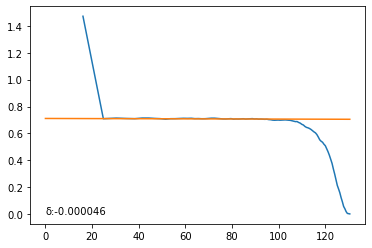

In [24]:
%%time
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.75,1,4,batch=1024,uszr=False)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 4.34279145e-10, -4.51791617e-08],
       [-4.51791617e-08,  4.80556074e-06]])

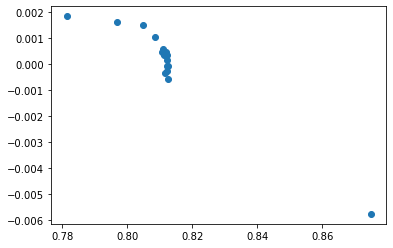

In [80]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.75000,1.00000]
0.875 -0.0026514614998875917
[0.75000,0.87500]
0.8125 0.0017775648483621725
[0.81250,0.87500]
0.84375 0.000993334308418206
[0.84375,0.87500]
0.859375 -0.005740847213030785
[0.84375,0.85938]
0.8515625 -0.002367105912197861
[0.84375,0.85156]
0.84765625 -0.00016280327271030244
[0.84375,0.84766]
0.845703125 0.00047514990065371574
[0.84570,0.84766]
0.8466796875 0.00013140482117122174
[0.84668,0.84766]
0.84716796875 -1.0704052030815906e-05
found α=0.84717±0.00049
Wall time: 50min 22s


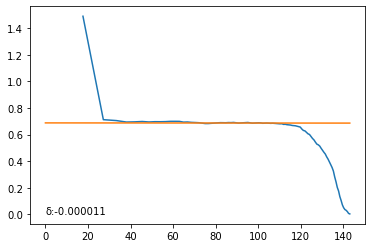

In [55]:
%%time
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.75,1,5,batch=1024,uszr=False)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 9.74575742e-10, -8.93258162e-08],
       [-8.93258162e-08,  8.26827298e-06]])

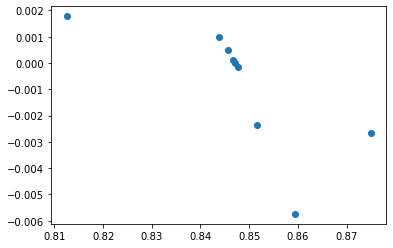

In [56]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.75000,1.00000]
0.875 -0.0022357634573514228
[0.75000,0.87500]
0.8125 0.0018486716810869018
[0.81250,0.87500]
0.84375 0.0016185291680137074
[0.84375,0.87500]
0.859375 0.001383497524692405
[0.85938,0.87500]
0.8671875 0.000599810515577412
[0.86719,0.87500]
0.87109375 0.0004843256481781491
[0.87109,0.87500]
0.873046875 -0.00035322553450867515
[0.87109,0.87305]
0.8720703125 0.00016509341067974675
[0.87207,0.87305]
0.87255859375 -0.0009244922793312049
[0.87207,0.87256]
0.872314453125 -0.0006317782153554777
[0.87207,0.87231]
0.8721923828125 -0.0010503665877937642
[0.87109,0.87219]
0.87164306640625 0.0001435263233909288
[0.87164,0.87219]
0.871917724609375 -0.00018608153128035876
[0.87164,0.87192]
0.8717803955078125 0.00019998893933397563
[0.87178,0.87192]
0.8718490600585938 -0.0005663524616751393
[0.87178,0.87185]
0.8718147277832031 -0.0001610650596349374
[0.87178,0.87181]
0.8717975616455078 -0.0001974468719410217
[0.87164,0.87180]
0.8717203140258789 -0.0003091252108066525
[0.87164,0.87172]

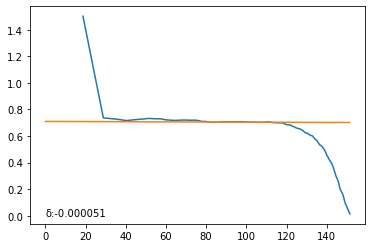

In [57]:
%%time
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.75,1,6,batch=1024,uszr=False)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 5.36803698e-10, -5.33401254e-08],
       [-5.33401254e-08,  5.34652575e-06]])

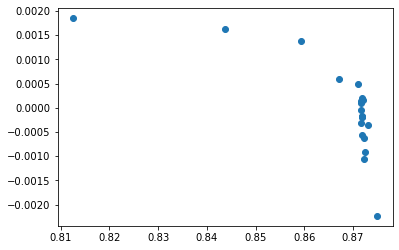

In [58]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.75000,1.00000]
0.875 0.0013635621959685058
[0.87500,1.00000]
0.9375 -0.0028710298347041203
[0.87500,0.93750]
0.90625 -0.002319026311433333
[0.87500,0.90625]
0.890625 -0.001738021991200589
[0.87500,0.89062]
0.8828125 0.0011010486262645516
[0.88281,0.89062]
0.88671875 0.0005825432041553257
[0.88672,0.89062]
0.888671875 -0.00017984035820365862
[0.88672,0.88867]
0.8876953125 0.00041606645081724794
[0.88770,0.88867]
0.88818359375 -9.198860146277654e-05
[0.88770,0.88818]
0.887939453125 0.00013244914993546463
[0.88794,0.88818]
0.8880615234375 -2.739293141452309e-06
found α=0.88806±0.00012
Wall time: 1h 27min 43s


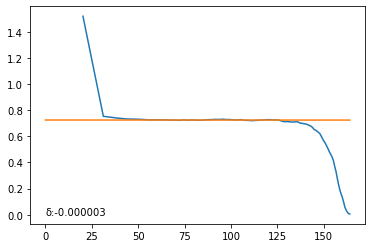

In [59]:
%%time
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.75,1,7,batch=1024,uszr=False)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 4.34279145e-10, -4.51791617e-08],
       [-4.51791617e-08,  4.80556074e-06]])

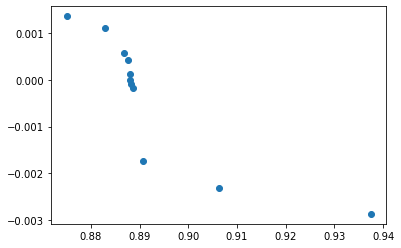

In [60]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.24500,0.26000]
0.2525 0.0001034569237022181
[0.25250,0.26000]
0.25625 -0.0005035477858574336
[0.25250,0.25625]
0.254375 -0.0002969995991689788
[0.25250,0.25438]
0.2534375 -0.00022699425900258297
[0.25250,0.25344]
0.25296874999999996 0.0007638641299165195
[0.25297,0.25344]
0.253203125 -0.00031983174356369057
[0.25297,0.25320]
0.25308593749999997 0.00045029860333112173
[0.25309,0.25320]
0.25314453124999997 -2.396194807094197e-05
found α=0.25314±0.00006


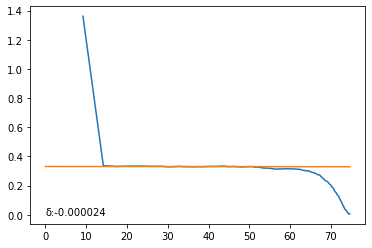

In [26]:
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.245,0.26,1,batch=1024,uszr=True)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 1.36602686e-09, -5.82817897e-08],
       [-5.82817897e-08,  2.53333985e-06]])

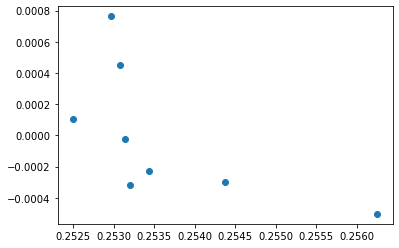

In [27]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.28000,0.36000]
0.32 0.0001608778806284231
[0.32000,0.36000]
0.33999999999999997 -0.0022128867881938893
[0.32000,0.34000]
0.32999999999999996 -0.0034393312102811314
[0.28000,0.33000]
0.305 0.0008991233166922
[0.30500,0.33000]
0.3175 0.0006068662100769853
[0.31750,0.33000]
0.32375 -0.0010990944617329322
[0.31750,0.32375]
0.320625 0.00024134658724516754
[0.32062,0.32375]
0.32218749999999996 -0.0003546603134621125
[0.32062,0.32219]
0.32140625 -0.00012054696459112181
[0.32062,0.32141]
0.321015625 5.399889475512402e-05
[0.32102,0.32141]
0.3212109375 -0.00017532059987836253
[0.32102,0.32121]
0.32111328125000005 -0.00012904434088311756
[0.32102,0.32111]
0.32106445312500004 -0.00015388738038476452
[0.32062,0.32106]
0.3208447265625 -0.0006778807273492073
[0.32062,0.32084]
0.32073486328125 7.306512498729207e-05
[0.32073,0.32084]
0.320789794921875 -0.000956875969641803
[0.32073,0.32079]
0.3207623291015625 -0.0004226332150571777
[0.32073,0.32076]
0.3207485961914063 0.00013164940277143997
[0.3207

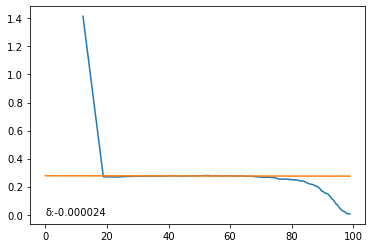

In [28]:
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.28,0.36,2,batch=1024,uszr=True)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 6.57242742e-10, -3.58772940e-08],
       [-3.58772940e-08,  2.00004705e-06]])

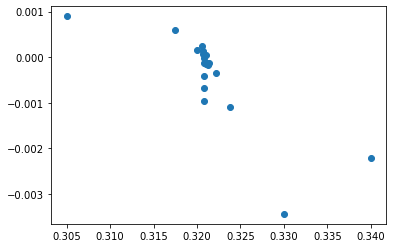

In [29]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.30000,0.40000]
0.35 0.00036062601487993334
[0.35000,0.40000]
0.375 -0.0019603821785359908
[0.35000,0.37500]
0.3625 -0.00220981050630335
[0.30000,0.36250]
0.33125 0.0007641791187955244
[0.33125,0.36250]
0.346875 0.000551519399633033
[0.34687,0.36250]
0.3546875 0.00014515209663324162
[0.35469,0.36250]
0.35859375 -0.002269733137385467
[0.35469,0.35859]
0.356640625 -0.0010589708307099733
[0.35469,0.35664]
0.3556640625 -0.0006436122728263973
[0.35469,0.35566]
0.35517578125 -0.0006977443232786843
[0.34687,0.35518]
0.351025390625 0.000426031839691987
[0.35103,0.35518]
0.3531005859375 -3.659711491249494e-05
found α=0.35310±0.00208


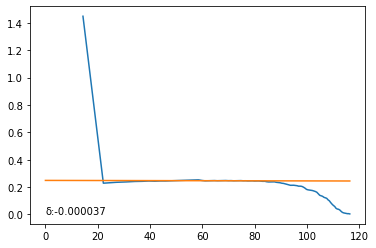

In [30]:
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.3,0.4,3,batch=1024,uszr=True)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 8.62969670e-10, -5.52054677e-08],
       [-5.52054677e-08,  3.66855173e-06]])

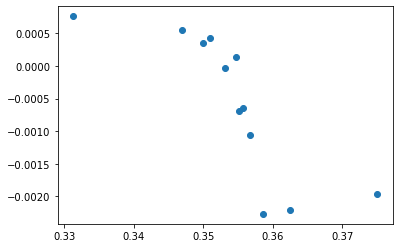

In [31]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.30000,0.50000]
0.4 -0.002460271071208223
[0.30000,0.40000]
0.35 0.0006443894485008159
[0.35000,0.40000]
0.375 4.066627354132003e-05
found α=0.37500±0.02500


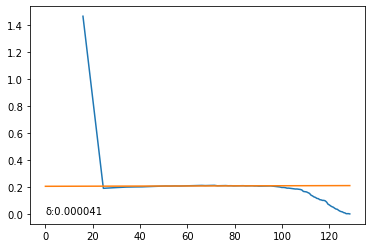

In [32]:
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.3,0.5,4,batch=1024,uszr=True)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 3.66827697e-10, -2.70216903e-08],
       [-2.70216903e-08,  2.07735450e-06]])

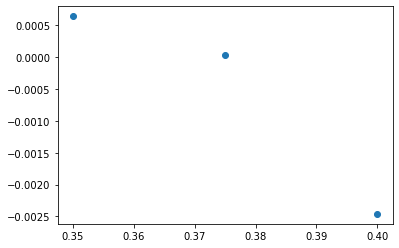

In [33]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.30000,0.50000]
0.4 -0.000924555521486681
[0.30000,0.40000]
0.35 0.0006867970005772899
[0.35000,0.40000]
0.375 0.0004421763609502131
[0.37500,0.40000]
0.3875 0.0003046384200971452
[0.38750,0.40000]
0.39375000000000004 4.703530021914614e-05
[0.39375,0.40000]
0.39687500000000003 -0.0001882391518115936
[0.39375,0.39688]
0.39531250000000007 0.00017646062519381938
[0.39531,0.39688]
0.39609375 -0.00030273345871515675
[0.39531,0.39609]
0.39570312500000004 -7.877391619464473e-05
[0.39531,0.39570]
0.39550781250000006 -4.4784040379154844e-05
found α=0.39551±0.00020


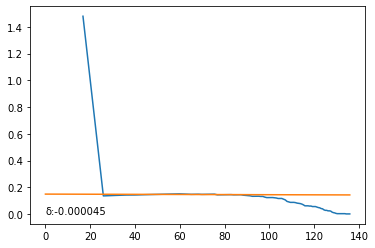

In [34]:
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.3,0.5,5,batch=1024,uszr=True)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 6.32162857e-10, -4.27577729e-08],
       [-4.27577729e-08,  3.01881481e-06]])

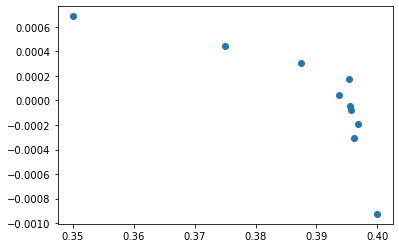

In [35]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.30000,0.50000]
0.4 0.00032624435738944795
[0.40000,0.50000]
0.45 -0.0004266698412793494
[0.40000,0.45000]
0.42500000000000004 -0.0011243207259462576
[0.30000,0.42500]
0.36250000000000004 0.0006097623256346223
[0.36250,0.42500]
0.39375000000000004 0.0003897493813959434
[0.39375,0.42500]
0.40937500000000004 -8.671167323750293e-06
found α=0.40938±0.01562


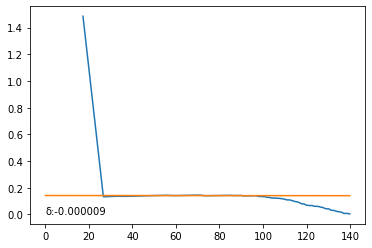

In [36]:
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.3,0.5,6,batch=1024,uszr=True)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 2.78236834e-10, -2.09752990e-08],
       [-2.09752990e-08,  1.64994268e-06]])

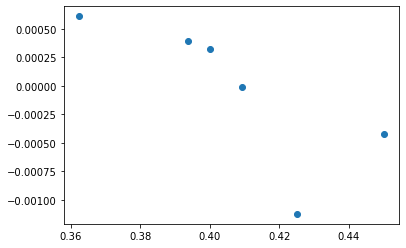

In [37]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

[0.30000,0.50000]
0.4 0.00035007050082872123
[0.40000,0.50000]
0.45 -0.0008267042411776018
[0.40000,0.45000]
0.42500000000000004 0.00011224377388321234
[0.42500,0.45000]
0.4375 -0.00015456641626501516
[0.42500,0.43750]
0.43125 -0.0008160553345436314
[0.40000,0.43125]
0.415625 0.00016364955091647114
[0.41563,0.43125]
0.4234375 9.808848885216789e-05
[0.42344,0.43125]
0.42734375 -0.0005224749268211637
[0.42344,0.42734]
0.425390625 -0.00012796260435557103
[0.42344,0.42539]
0.4244140625 -0.0002041067432080291
[0.41563,0.42441]
0.42001953125 0.00020409701552818495
[0.42002,0.42441]
0.422216796875 0.00024090003738185879
[0.42222,0.42539]
0.4238037109375 -5.560996851728397e-06
found α=0.42380±0.00159


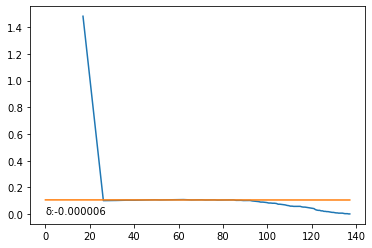

In [38]:
a,a_sigma,f,sizes,his,cov=alpha_search(256,0,0.3,0.5,7,batch=1024,uszr=True)
print("found α={:.5f}±{:.5f}".format(a,a_sigma))
plt_critical(sizes)

array([[ 2.02041019e-10, -1.34742983e-08],
       [-1.34742983e-08,  9.33358621e-07]])

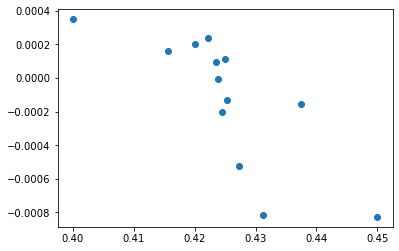

In [39]:
plt.scatter(his[:,0],his[:,1])
plt.draw()
cov

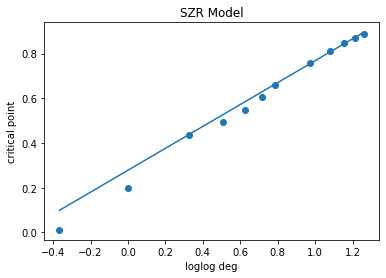

In [163]:
plt.axes(xlabel='loglog deg',ylabel='critical point',title='SZR Model')
x,y=np.log(np.log(np.arange(1,8)*5-1)),[0.43699,0.66053,0.75820,0.8122243881225586,0.84717,0.87170,0.8880615234375]
k,b=np.polyfit(x,y,1)
x=np.concatenate((np.log(np.log([0.6*5-1,0.743656365691809*5-1,1.25*5-1,1.5*5-1,1.75*5-1])),x))
y=np.concatenate(([0.01104,0.19727,0.49179,0.5459194946289063,0.6061816406249999],y))
plt.plot(np.sort(x),np.sort(k*x+b))
plt.scatter(x,y)
plt.draw()

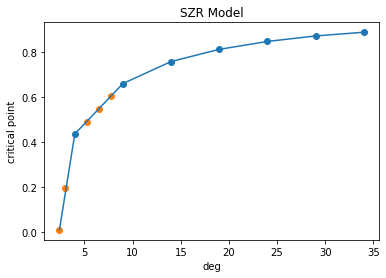

In [182]:
plt.axes(xlabel='deg',ylabel='critical point',title='SZR Model')
x,y=(np.arange(1,8)*5-1),[0.43699,0.66053,0.75820,0.8122243881225586,0.84717,0.87170,0.8880615234375]
plt.scatter(x,y)
plt.plot(np.concatenate(([0.6*4],x)),np.concatenate(([0.01104],y)))
k,b=np.polyfit(x,y,1)
x=[0.6*4,0.743656365691809*4,1.25*5-1,1.5*5-1,1.75*5-1]
y=[0.01104,0.19727,0.49179,0.5459194946289063,0.6061816406249999]
plt.scatter(x,y)
plt.draw()

The behavior might have something to do with the variance of degree distribution: A model with avg multiplicity $n$ is obtained with each site having $\lfloor n \rfloor$ or $\lceil n \rceil$ people with a weighted binary distribution.

Though not really likely, it would be interesting if the critical point can be gained from superposition of models with different multiplicity.

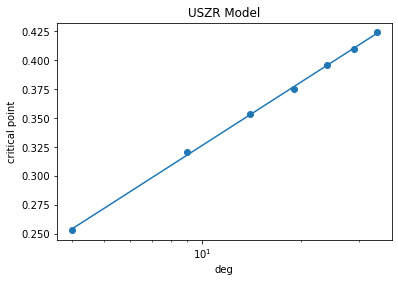

In [184]:
x,y=np.arange(1,8)*5-1,[0.25314453124999997,0.3207520294189453,0.3531005859375,0.375,0.39550781250000006,0.40937500000000004,0.4238037109375]
k,b=np.polyfit(np.log(x),y,1)
plt.axes(xlabel='deg',ylabel='critical point',title='USZR Model')
plt.scatter(x,y)
plt.plot(x,k*np.log(x)+b)
plt.xscale('log')
plt.draw()